In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalMaxPooling2D
import openslide
from openslide import OpenSlide
import cv2 

In [2]:
train_df = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
test_df  = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')

In [3]:
train_df.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


In [4]:
train_df["file_path"] = train_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/train/" + x + ".tif")
test_df["file_path"]  = test_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/test/" + x + ".tif")

In [5]:
train_df["target"] = train_df["label"].apply(lambda x : 1 if x=="CE" else 0)

In [6]:
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path,target
0,006388_0,11,006388,0,CE,../input/mayo-clinic-strip-ai/train/006388_0.tif,1
1,008e5c_0,11,008e5c,0,CE,../input/mayo-clinic-strip-ai/train/008e5c_0.tif,1
2,00c058_0,11,00c058,0,LAA,../input/mayo-clinic-strip-ai/train/00c058_0.tif,0
3,01adc5_0,11,01adc5,0,LAA,../input/mayo-clinic-strip-ai/train/01adc5_0.tif,0
4,026c97_0,4,026c97,0,CE,../input/mayo-clinic-strip-ai/train/026c97_0.tif,1


The size of the image is(8267, 10533, 3)


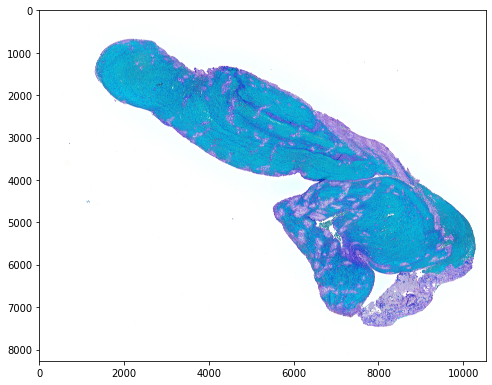

CPU times: user 9.17 s, sys: 1.55 s, total: 10.7 s
Wall time: 11 s


In [7]:
%%time
import cv2
from PIL import Image
import tifffile as tifi
j = 4
sample_train = train_df[j:j+1]

img = cv2.imread(sample_train.loc[j, "file_path"])
print('The size of the image is' + str(img.shape))
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.show()  

2022-09-19 17:35:16.296420: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


The size of the image is(512, 512, 3)


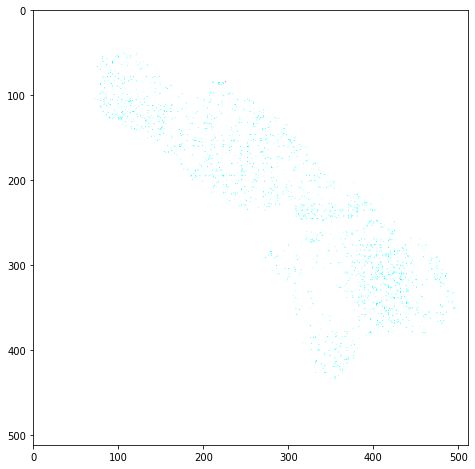

In [8]:
image_resized = tf.image.resize(img, (512, 512))
print('The size of the image is' + str(image_resized.shape))
plt.figure(figsize=(8, 8))
plt.imshow(image_resized)
plt.show()  

CPU times: user 27.8 s, sys: 8.13 s, total: 35.9 s
Wall time: 1min 12s


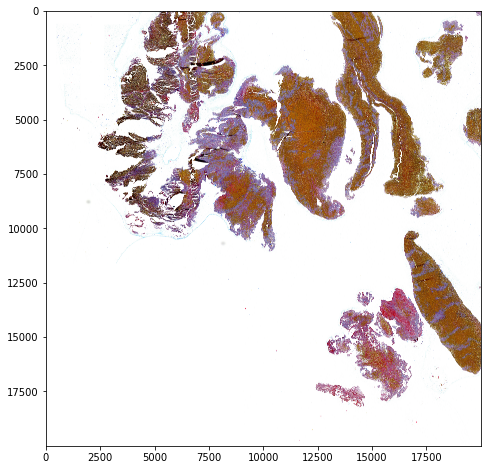

In [9]:
%%time
sample_train = train_df[:4]

for i in range(1):
    slide = OpenSlide(sample_train.loc[i, "file_path"])
    region = (0, 0)
    size = (20000, 20000)
    region = slide.read_region(region, 0, size)
    plt.figure(figsize=(8, 8))
    plt.imshow(region)

In [10]:
%%time
def preprocess(image_path):
    slide=OpenSlide(image_path)
    region= (0,0)    
    size  = (15000, 15000)
    image = slide.read_region(region, 0, size)
    #print('imgae shape is' + str(image.size))
    image = tf.image.resize(image, (224, 224),method=tf.image.ResizeMethod.LANCZOS5)
    image = np.array(image) / 255.0 # Normalization
    #image = np.array(image)
    return image

x_train=[]
# num_img = 10
# counter = 0
for i in tqdm(train_df['file_path']):
    x1=preprocess(i)
    #print(x1.shape)
    x_train.append(x1[:,:,0:3]) # Channel four is useless
#     counter += 1
#     if (counter == num_img):
#         break
    

100%|██████████| 754/754 [5:59:22<00:00, 28.60s/it]

CPU times: user 2h 15min 50s, sys: 53min 18s, total: 3h 9min 8s
Wall time: 5h 59min 22s


In [11]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights. 
Input size is 224 x 224.
'''

feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                           include_top=False,
                                           weights='imagenet')
# freeze the layers
# for layer in feature_extractor.layers:
#   layer.trainable = False

'''
Defines final dense layers and subsequent softmax layer for classification.
'''
x = tf.keras.layers.GlobalAveragePooling2D()(feature_extractor.output)
# Flatten the output layer to 1 dimension
x = layers.Flatten()(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1)(x)

model = tf.keras.Model(feature_extractor.input, x)

model.compile(
      loss = tf.keras.losses.MeanSquaredError(),    
      metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse"), tf.keras.metrics.BinaryAccuracy(name="accuracy")],
      optimizer = tf.keras.optimizers.Adam(1e-3))

# model.summary()

94781440/94765736 [==============================] - 1s 0us/step


In [12]:
x_train=np.array(x_train)
#y_train=train_df['target'][0:num_img]
y_train=train_df['target']

x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,test_size=0.2)

In [13]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # All images will be rescaled by 1./255
# train_datagen = ImageDataGenerator(rescale=1/255)
# validation_datagen = ImageDataGenerator(rescale=1/255)

# # Flow training images in batches of 128 using train_datagen generator
# train_generator = train_datagen.flow_from_dataframe(
#         train_df[0:10],  
#         x_col = 'file_path'.
#         y_col = 'target'
#         target_size=(224,224),  # All images will be resized to 224*224
#         batch_size=32,
#         # Since you use binary_crossentropy loss, you need binary labels
#         class_mode='binary')

# # Flow validation images in batches of 128 using validation_datagen generator
# train_generator = train_datagen.flow_from_dataframe(
#         train_df[10:20],  # This is the source directory for training images
#         x_col = 'file_path'.
#         y_col = 'target'
#         target_size=(224,224),  # All images will be resized to 300x300
#         batch_size=32,
#         # Since you use binary_crossentropy loss, you need binary labels
#         class_mode='binary')

In [14]:
%%time

import math
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, Callback, ReduceLROnPlateau, ModelCheckpoint

# def step_decay(epoch):
#     initial_lrate = 0.001
#     drop = 0.5
#     epochs_drop = 20.0
#     lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
#     return lrate

# lrate = LearningRateScheduler(step_decay)
# earstop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5)
lrate = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience= 20,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.00000001,
)

model_checkpoint_callback = ModelCheckpoint(
    filepath='/kaggle/working/resnet50_model.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(
    x_train,
    y_train,
    epochs = 100,
    batch_size=32,
    validation_data = (x_test,y_test),
    verbose = 1,
    callbacks = [lrate, model_checkpoint_callback]
)

2022-09-19 23:36:24.934557: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
19/19 [==============================] - 179s 9s/step - loss: 4.9910 - rmse: 2.2340 - accuracy: 0.4196 - val_loss: 29.2202 - val_rmse: 5.4056 - val_accuracy: 0.7285
Epoch 2/100
19/19 [==============================] - 161s 9s/step - loss: 1.3147 - rmse: 1.1466 - accuracy: 0.3632 - val_loss: 5.3520 - val_rmse: 2.3134 - val_accuracy: 0.7285
Epoch 3/100
19/19 [==============================] - 161s 8s/step - loss: 1.0063 - rmse: 1.0032 - accuracy: 0.3532 - val_loss: 8.4872 - val_rmse: 2.9133 - val_accuracy: 0.7285
Epoch 4/100
19/19 [==============================] - 161s 9s/step - loss: 0.7391 - rmse: 0.8597 - accuracy: 0.3715 - val_loss: 0.3067 - val_rmse: 0.5538 - val_accuracy: 0.7285
Epoch 5/100
19/19 [==============================] - 161s 9s/step - loss: 0.6344 - rmse: 0.7965 - accuracy: 0.3350 - val_loss: 0.5020 - val_rmse: 0.7085 - val_accuracy: 0.2715
Epoch 6/100
19/19 [==============================] - 161s 8s/step - loss: 0.5471 - rmse: 0.7396 - accuracy: 0.3914 - va

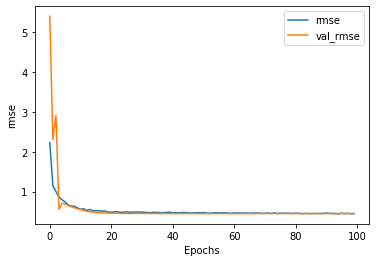

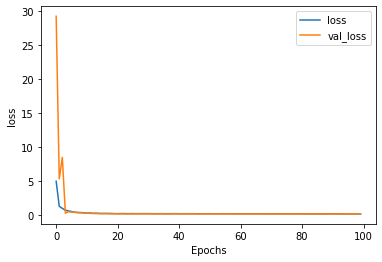

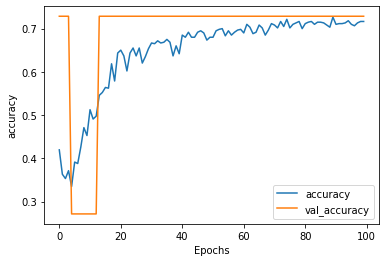

In [15]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.savefig(str(metric) +'.png')
    plt.show()
    
plot_graphs(history, "rmse")
#plt.savefig('accuracy.png')
plot_graphs(history, "loss")
#plt.savefig('loss.png')
plot_graphs(history, "accuracy")

In [16]:
#model.summary()

In [17]:
#del train_df, x_train
gc.collect()

11466

In [18]:
model = tf.keras.models.load_model('/kaggle/working/resnet50_model.h5')

In [19]:
test1=[]
for i in test_df['file_path']:
    x1=preprocess(i)
    test1.append(x1[:,:,0:3])
test1=np.array(test1)

cnn_pred=model.predict(test1)

In [20]:
cnn_pred

array([[0.71887785],
       [0.6684509 ],
       [0.70104015],
       [0.667632  ]], dtype=float32)

In [21]:
sub = pd.DataFrame(test_df["patient_id"].copy())
sub["CE"] = cnn_pred
sub["CE"] = sub["CE"].apply(lambda x : 0 if x<0 else x)
sub["CE"] = sub["CE"].apply(lambda x : 1 if x>1 else x)
sub["LAA"] = 1- sub["CE"]

sub = sub.groupby("patient_id").mean()
sub = sub[["CE", "LAA"]].round(6).reset_index()
sub

,patient_id,CE,LAA
0,006388,0.718878,0.281122
1,008e5c,0.668451,0.331549
2,00c058,0.701040,0.298960
3,01adc5,0.667632,0.332368


In [22]:
sub.to_csv("submission.csv", index = False)
!head submission.csv

patient_id,CE,LAA
006388,0.718878,0.281122
008e5c,0.668451,0.331549
00c058,0.70104,0.29896
01adc5,0.667632,0.332368
